In [4]:
import numpy as np
import sys
from math import cos, radians
import matplotlib.transforms as mtransforms
from shapely.geometry import Polygon
import nest_asyncio
import math 
import datetime
from geopy import distance
from math import cos
from haversine import haversine, Unit
from pyproj import Proj
import osmnx as ox
import pyproj
import pints

#import rasterio
import random
from natsort import natsorted,realsorted, ns
from tqdm.notebook import trange, tqdm
from time import sleep
import osmnx as ox
import haversine as hs
import shutil
from numpy import asarray
from IPython import display
import os
from os import listdir
import utm
import geopandas
from pathlib import Path
import glob
import concurrent.futures
from scipy.spatial.transform import Rotation
import geotiler

import pandas as pd
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import aic, bic

 
import matplotlib.pyplot as plt
import h5py
import mplleaflet
from PIL import Image, ImageDraw
print(mplleaflet.__file__)

c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\mplleaflet\__init__.py


In [3]:
Logname = 'AtCityBMW_Applanix-20220601T115459Z469'
path = 'C:/Users/bjqb7h/Downloads/Thesis2022/GPS DATA/'
path_position = 'sensors/ApplanixDGPS'
path_orientation = 'sensors/ApplanixDGPS/orientation'
path_timestamps = 'sensors/ApplanixDGPS/timestamps'
path_meta = 'C:/Users/bjqb7h/Downloads/Thesis2022/Meta/'
path_save ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset'

In [4]:
#Read Hdf5 filel for the Radar data and GPS data.
hf1 = h5py.File(path+Logname+'.h5','r')
dset = hf1[path_position]['position']
dset1= hf1[path_orientation]
dsetA = hf1.get(path_timestamps)
GPSTimestamp=np.array(dsetA)



hf2 = h5py.File(path_meta+Logname+'.h5','r')
dsetB= hf2.get('radar_timestamps')
dsetB=np.array(dsetB)
Radar1Timestamp = dsetB[:,0]
Radar1Timestamp = np.round(Radar1Timestamp,2)#RadarTime stamps 
GPSTimestamp= np.round(GPSTimestamp,2)#GPS


#Extract all the Latitudes,Longitude and Orientation(Quaternions) 
Long=dset[:,0] #Longitude
Lat=dset[:,1]  #Latitude
q0=dset1[:,0]  #Quaternions 1
q1=dset1[:,1]  #Quaternions 2
q2=dset1[:,2]  ##Quaternions 3
q3=dset1[:,3] ##Quaternions 4

size= len(Long) #Size of the dataset ususally len(long)

nest_asyncio.apply()

In [5]:
dgps_ts = GPSTimestamp
radar_ts = Radar1Timestamp

dgps_sync = []
for i in range(len(GPSTimestamp)):
    # Check if a match is found with any radar timestamp
    if (GPSTimestamp[i] == Radar1Timestamp[:]).any():
        # Append index to dgps_sync array
        dgps_sync.append(i)
        
        
A=len(dgps_sync)
org_lat =np.zeros(A,dtype =np.float64)
org_long =np.zeros(A,dtype =np.float64)
gps_lat =np.zeros(A,dtype =np.float64)
gps_long =np.zeros(A,dtype =np.float64)
org_lat = Lat[dgps_sync]
org_long = Long[dgps_sync]

print(A)

2093


In [6]:
def calculate_rmse(dgps_longitude, dgps_latitude, gps_longitude, gps_latitude):
    assert len(dgps_longitude) == len(gps_longitude), "Arrays must have the same length"
    assert len(dgps_latitude) == len(gps_latitude), "Arrays must have the same length"

    squared_diff_sum = 0.0
    num_frames = len(dgps_longitude)

    for i in range(num_frames):
        dgps_long = dgps_longitude[i]
        dgps_lat = dgps_latitude[i]
        gps_long = gps_longitude[i]
        gps_lat = gps_latitude[i]
        diff_long = dgps_long - gps_long
        diff_lat = dgps_lat - gps_lat
        squared_diff_sum += (diff_long ** 2 + diff_lat ** 2)

    mean_squared_diff = squared_diff_sum / num_frames
    rmse = math.sqrt(mean_squared_diff)
    conversion_factor_latitude = 111000

    return rmse*conversion_factor_latitude

In [7]:
# import numpy as np

# # Generate a sine wave sequence
# np.random.seed(0)
# t = np.arange(0, 10, 0.1)  # Time points
# signal = np.sin(t)  # Sine wave signal
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

t=np.arange(0,2093,1)
signal=longitude
# Fit AR model of order 1
order_1_model = AutoReg(signal, lags=1)
order_1_results = order_1_model.fit()
ar1_noise = order_1_results.resid

# Fit AR model of order 2
order_2_model = AutoReg(signal, lags=5)
order_2_results = order_2_model.fit()
ar2_noise = order_2_results.resid

# Generate predictions
order_1_predictions = order_1_results.predict(start=0, end=len(signal)-1)
order_2_predictions = order_2_results.predict(start=0, end=len(signal)-1)

# Plot original signal and predictions
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, order_1_predictions, label='AR(1) Predictions')
plt.plot(t, order_2_predictions, label='AR(2) Predictions')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('AR Model of Order 1 and Order 2')
plt.show()


NameError: name 'longitude' is not defined

In [8]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

def add_ar_noise(Long, Lat, ar_order, scaling_factor):
    # Create an AR model using the given order and coefficients
    ar_model_long = AutoReg(Long, lags=ar_order,trend='ct')
    ar_model_lat = AutoReg(Lat, lags=ar_order,trend='ct')
    
    # Fit the AR model to the data
    ar_resul_long = ar_model_long.fit()
    ar_resul_lat = ar_model_lat.fit()
    
    #use resid function
    ar_resul_long_res = ar_resul_long.resid
    ar_resul_lat_res = ar_resul_lat.resid

    # Scale the AR noise by the desired factor
    scaled_ar_noise_long = scaling_factor * ar_resul_long_res
    scaled_ar_noise_lat = scaling_factor * ar_resul_lat_res
    
    #removing NAN for lags
    scaled_ar_noise_long = np.nan_to_num(scaled_ar_noise_long, nan=0)
    scaled_ar_noise_lat = np.nan_to_num(scaled_ar_noise_lat, nan=0)
    
    
    # Add the scaled AR noise to the longitude and latitude
    x_noisy = Long.copy()
    y_noisy = Lat.copy()
    
    print("The STD value of noise in Long between DGPS and AR PREDICTION ",ar_resul_long_res.std())
    print("The STD value of noise in Lat between DGPS and AR PREDICTION ",ar_resul_lat_res.std())
    
    print("The STD value of noise after scaling in Long between DGPS and AR PREDICTION ",scaled_ar_noise_long.std())
    print("The STD value of noise after scaling in Lat between DGPS and AR PREDICTION ",scaled_ar_noise_lat.std())
    
    
    
    pad_width = (ar_order[0], 0)  # (before, after) padding widths
    scaled_ar_noise_long = np.pad(scaled_ar_noise_long, pad_width, mode='constant')
    scaled_ar_noise_lat  = np.pad(scaled_ar_noise_lat, pad_width, mode='constant')
    
    np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\\' + 'dxGTAR', scaled_ar_noise_long)
    np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\\' + 'dyGTAR', scaled_ar_noise_lat)
    
    x_noisy = x_noisy +scaled_ar_noise_long
    y_noisy = y_noisy +scaled_ar_noise_lat
    
    return x_noisy,y_noisy,scaled_ar_noise_long,scaled_ar_noise_lat

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The STD value of noise in Long between DGPS and AR PREDICTION  1.175705314595504e-05
The STD value of noise in Lat between DGPS and AR PREDICTION  6.073796550617448e-06
The STD value of noise after scaling in Long between DGPS and AR PREDICTION  1.175705314595504e-05
The STD value of noise after scaling in Lat between DGPS and AR PREDICTION  6.073796550617448e-06


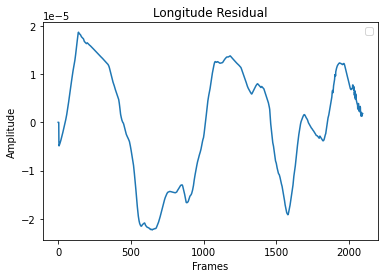

In [9]:
ar_order = [5]  # AR model order
scaling_factor =1 # Adjust this value to control the magnitude of the noise
x_noisy,y_noisy,scaled_ar_noise_long,scaled_ar_noise_lat= add_ar_noise(org_long, org_lat, ar_order, scaling_factor)

plt.plot(scaled_ar_noise_long)
plt.title("Longitude Residual")
plt.xlabel("Frames")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Histogram of Latitude noise added')

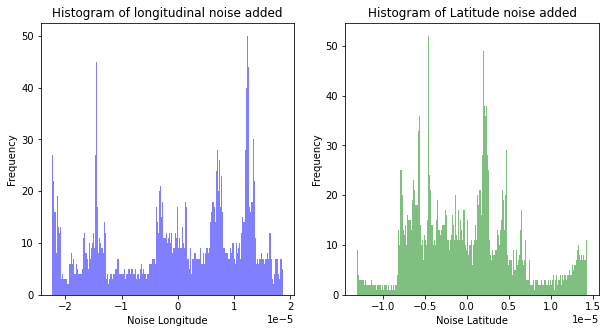

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(scaled_ar_noise_long, bins=216, color='blue', alpha=0.5)
axs[0].set_xlabel('Noise Longitude')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of longitudinal noise added')

axs[1].hist(scaled_ar_noise_lat, bins=216, color='green', alpha=0.5)
axs[1].set_xlabel('Noise Latitude')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Latitude noise added')



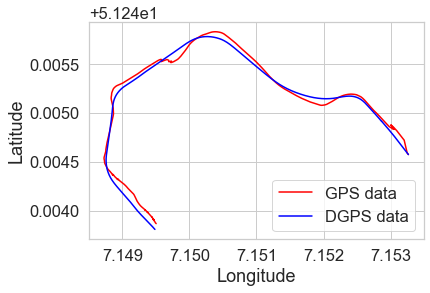

(2093,)


In [891]:
plt.plot(x_noisy,y_noisy,'r-',label='GPS data')
plt.plot(org_long,org_lat,'b-',label='DGPS data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
#mplleaflet.display()
print(x_noisy.shape)


In [871]:
print(calculate_rmse(org_long,org_lat,x_noisy,y_noisy))

7.074362658035222


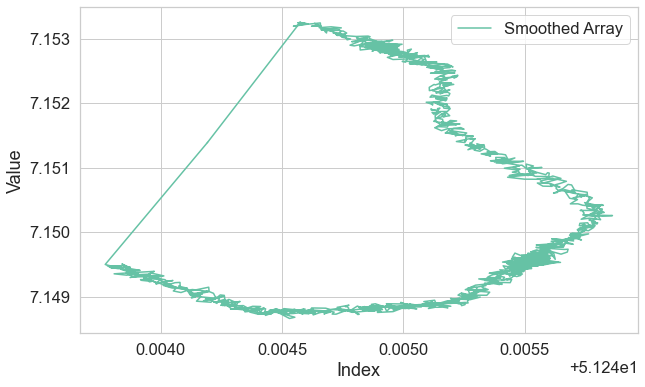

In [884]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    data_padded = np.concatenate((data[-window_size + 1:], data, data[:window_size - 1]))
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data_padded, window, mode='valid')
    return smoothed

# Apply moving average filter
window_size = 2
smoothed_noisy_Lat = moving_average(x_noisy, window_size)
smoothed_noisy_Long = moving_average(y_noisy, window_size)

# Plot the original noisy array and the smoothed array
plt.figure(figsize=(10, 6))
#plt.plot(x_noisy,y_noisy, label='Noisy Array')
plt.plot(smoothed_noisy_Long,smoothed_noisy_Lat, label='Smoothed Array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [881]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg



ar_order = 1

# Step 2: Fit AR model to DGPS data
model_longitude = AutoReg(org_long,lags=ar_order)
model_latitude = AutoReg(org_lat,lags=ar_order)

# Order of the AR model

ar_model_longitude = model_longitude.fit()
ar_model_latitude = model_latitude.fit()

# Step 3: Retrieve model parameters
intercept_longitude = ar_model_longitude.params[0]
coefficient_longitude = ar_model_longitude.params[1]

intercept_latitude = ar_model_latitude.params[0]
coefficient_latitude = ar_model_latitude.params[1]

# Step 4: Generate noise
mean = 0  # Mean of the noise
std_dev = 0.00002  # Standard deviation of the noise

noise_longitude = np.random.normal(mean, std_dev, len(org_long))
noise_latitude = np.random.normal(mean, std_dev, len(org_long))

# Step 5: Generate synthetic GPS data

synthetic_longitude = intercept_longitude + coefficient_longitude * org_long + noise_longitude
synthetic_latitude = intercept_latitude + coefficient_latitude * org_lat + noise_latitude

# Print the synthetic GPS data
print("Synthetic Longitude:", synthetic_longitude)
print("Synthetic Latitude:", synthetic_latitude)


Synthetic Longitude: [7.15328126 7.15327329 7.15327493 ... 7.14947867 7.14949089 7.1494611 ]
Synthetic Latitude: [51.24456968 51.24458195 51.24454979 ... 51.24378838 51.24378762
 51.24383027]


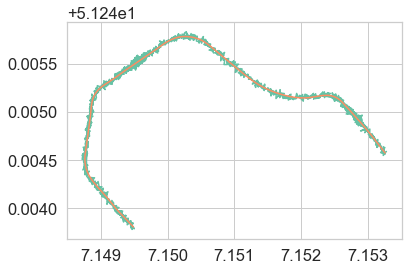

In [867]:
plt.plot(synthetic_longitude,synthetic_latitude)
plt.plot(org_long,org_lat)


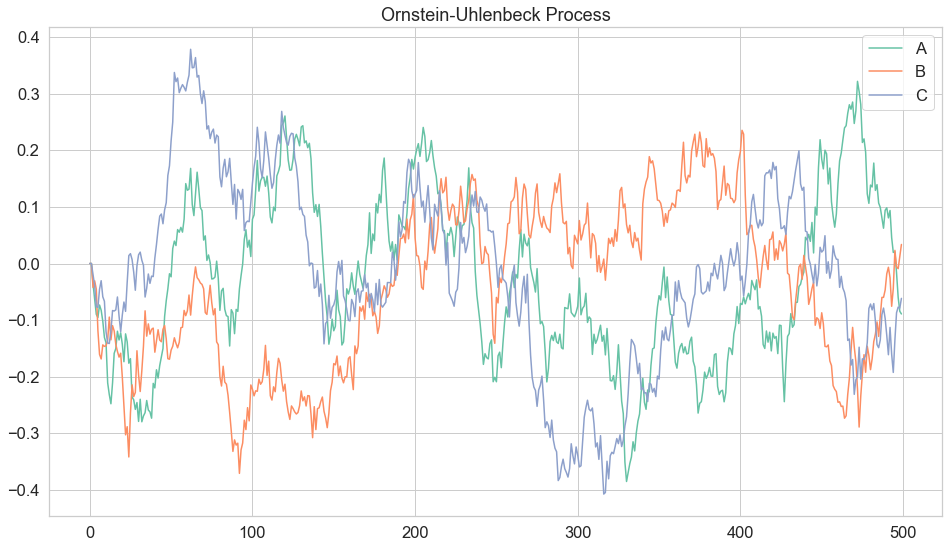

In [844]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.set_context('notebook', font_scale=1.5)

dt = 0.1

theta = 0.15 # friction: strength to pull towards the mean
sigma = 0.3 # noise
mu = 0.0 # global mean

processes = 3
samples = 500

X = np.zeros(shape=(samples, processes))
for t in range(1, samples - 1):
    dw = norm.rvs(scale=dt, size=processes) # W: Wierner process, dw: brownian velocity
    dx = theta * (mu - X[t]) * dt + sigma * dw
    X[t+1] = X[t] + dx

plt.figure(figsize=(16, 9))
plt.plot(X)
plt.title('Ornstein-Uhlenbeck Process')
plt.legend(['A', 'B', 'C'])

In [857]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.set_context('notebook', font_scale=1.5)

dt = 0.001#the time step or interval at which the process is sampled.

theta = 0.00020  # Friction: strength to pull towards the mean
sigma = 0.01  # Noise
mu = 0.0  # Global mean

processes = 2  # DGPS longitude and latitude
samples = len(org_long)

dgps_longitude = np.zeros(samples)
dgps_latitude = np.zeros(samples)

dx_longitude = np.zeros(samples)
dx_latitude = np.zeros(samples)




for t in range(1, samples - 1):
    dw = norm.rvs(scale=dt, size=processes)  # W: Wiener process, dw: Brownian velocity
    dx_longitude[t] = theta * (mu - org_long[t]) * dt + sigma * dw[0]
    dx_latitude[t] = theta * (mu - org_lat[t]) * dt + sigma * dw[1]




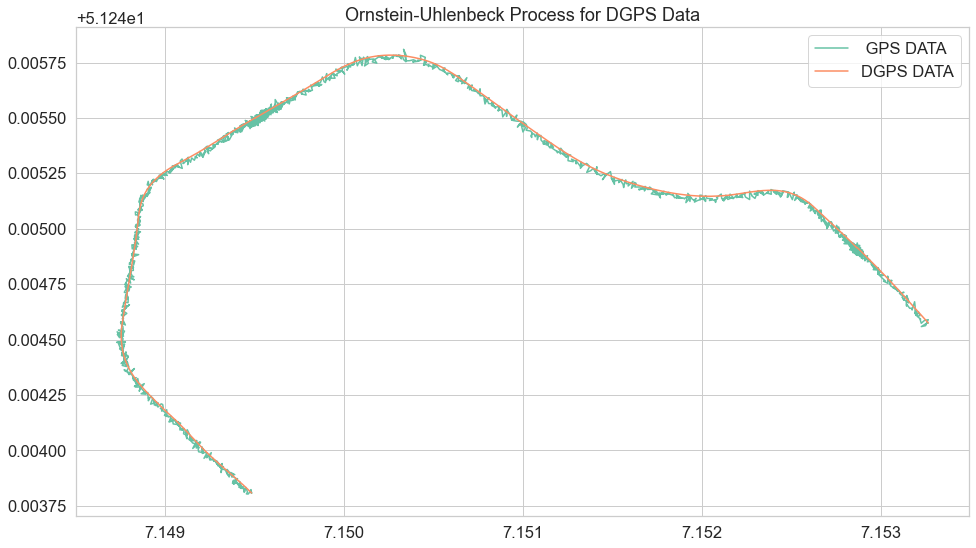

In [859]:
plt.figure(figsize=(16, 9))
new_long = org_long + dx_longitude
new_lat = org_lat + dx_latitude
plt.plot(new_long,new_lat,label=" GPS DATA ")
plt.plot(org_long,org_lat, label = "DGPS DATA")
plt.title('Ornstein-Uhlenbeck Process for DGPS Data')
plt.legend()
plt.show()


In [584]:
import numpy as np
import statsmodels.api as sm
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

def simulate_gps_data(dgps_longitude, dgps_latitude, noise_std):
    # Fit ARMA model to longitude and latitude separately
    arma_model_longitude = ARIMA(dgps_longitude, order=(4,0,0)).fit()
    arma_model_latitude = ARIMA(dgps_latitude, order=(4,0,0)).fit()
    
    # Generate residuals from the ARMA models
    residuals_longitude = arma_model_longitude.resid
    residuals_latitude = arma_model_latitude.resid
    
    # Add Gaussian noise to the residuals
    noise_longitude = np.random.normal(0, noise_std, size=len(residuals_longitude))
    noise_latitude = np.random.normal(0, noise_std, size=len(residuals_latitude))
    
    noisy_residuals_longitude = residuals_longitude + noise_longitude
    noisy_residuals_latitude = residuals_latitude + noise_latitude
    
    # Generate simulated GPS data by adding the noisy residuals to the DGPS data
    gps_longitude = dgps_longitude + noisy_residuals_longitude
    gps_latitude = dgps_latitude + noisy_residuals_latitude
    
    return gps_longitude, gps_latitude


In [711]:
g_long,g_lat = simulate_gps_data(org_long,org_lat,0.00005)

c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


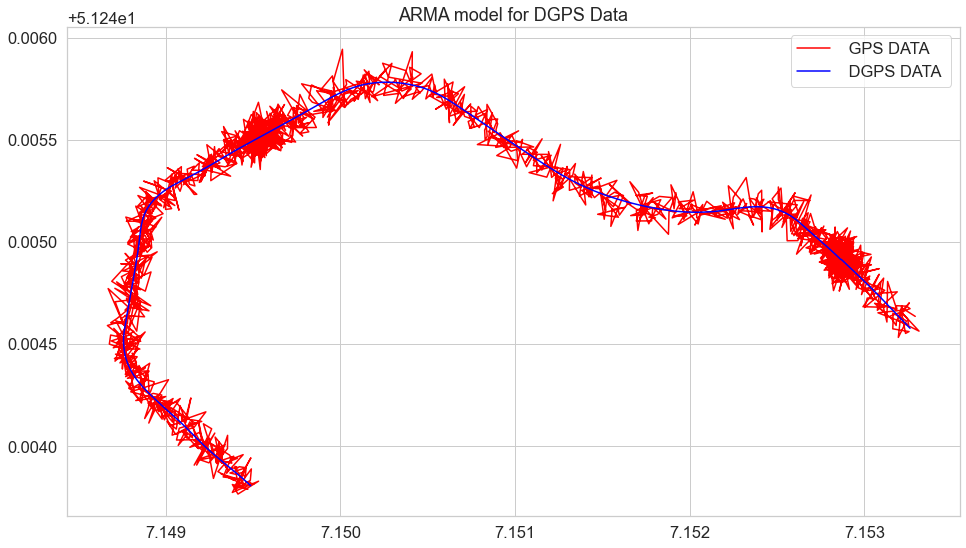

In [712]:
plt.figure(figsize=(16, 9))
plt.plot(g_long[1:],g_lat[1:],'r-',label=" GPS DATA ")
plt.plot(org_long[1:],org_lat[1:],'b-',label=" DGPS DATA ")
plt.title('ARMA model for DGPS Data')
plt.legend()
plt.show()

In [11]:
def decimal_degrees_to_meters(distance_in_decimal_degrees, latitude):
    conversion_factor = 111320 * math.cos(math.radians(latitude))
    distance_in_meters = distance_in_decimal_degrees * conversion_factor
    return distance_in_meters

# Example usage
distance_in_decimal_degrees =6.073796550617448e-06

latitude = org_lat.mean()  # New York City
distance_in_meters = decimal_degrees_to_meters(distance_in_decimal_degrees, latitude)
print(f"0.00005 decimal degrees is approximately {distance_in_meters} meters at latitude {latitude}.")

0.00005 decimal degrees is approximately 0.4232538016915588 meters at latitude 51.2451086470798.


In [153]:
import numpy as np

# Load the image log data from the npy file
#image_log = np.load(r"C:\Users\bjqb7h\Downloads\Thesis2022\NUMPY\New\AtCityBMW_Applanix-20220601T115459Z469GPSNOISE1.npy")
log='AtCityBMW_Applanix-20220601T115459Z469'

GPS = h5py.File('C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New/AtCityBMW_Applanix-20220601T115459Z469GPSNOISE1.hdf5','r')
image_log= GPS.get(log+'/Image data')

# Semseg = h5py.File('C:/Users/bjqb7h/Downloads/Thesis2022/SEMSEGGPS/AtCityBMW_Applanix-20220601T115459Z469.h5','r')
# image_log= Semseg.get('grid_prediction')
# image_log = np.reshape(image_log,(2093,160,160,2))

# Shuffle the image log data
#np.random.shuffle(image_log)

# Define the proportions of data to allocate for training, validation, and testing
train_ratio = .6  # 60% for training
val_ratio = .2  # 20% for validation
test_ratio = .2  # 20% for testing

# Calculate the number of frames for training, validation, and testing
num_frames = image_log.shape[0]
num_train_frames = int(train_ratio * num_frames)
num_val_frames = int(val_ratio * num_frames)
num_test_frames = num_frames - num_train_frames - num_val_frames

# Split the image log into training, validation, and testing datasets
train_data = image_log[:num_train_frames]
val_data = image_log[num_train_frames:num_train_frames+num_val_frames]
test_data = image_log[num_train_frames+num_val_frames:]

train_data_single_channel = train_data[..., 1]
val_data_single_channel = val_data[..., 1]
test_data_single_channel = test_data[..., 1]

# Save the training, validation, and testing datasets as npy files
np.save(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\train_data.npy", train_data_single_channel)
np.save(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\val_data.npy", val_data_single_channel)
np.save(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\test_data.npy", test_data_single_channel)


In [154]:
train = np.load(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\train_data.npy")
t_semseg= np.load(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\Semseg\train_data.npy")
print(train.shape,t_semseg.shape)

(1255, 160, 160) (1255, 160, 160)


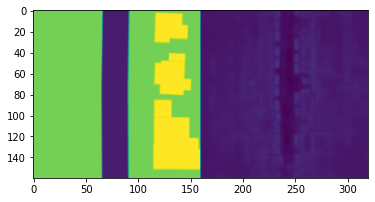

In [155]:
plt.imshow(np.hstack((train[40],t_semseg[40])))

In [59]:
print(train[1].max(),train[1].min())

165 0


In [145]:
import numpy as np

total_frames = 2093
validation_frames = 41

# log='AtCityBMW_Applanix-20220601T115459Z469'

# GPS = h5py.File('C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New/AtCityBMW_Applanix-20220601T115459Z469GPSNOISE1.hdf5','r')
# image_log= GPS.get(log+'/Image data')

Semseg = h5py.File('C:/Users/bjqb7h/Downloads/Thesis2022/SEMSEGGPS/AtCityBMW_Applanix-20220601T115459Z469.h5','r')
image_log= Semseg.get('grid_prediction')
image_log = np.reshape(image_log,(2093,160,160,2))

# Extract the validation set from the last `validation_frames` frames
validation_set = image_log[41:82]

validation_set = validation_set[..., 1]

# Save the validation set as .npy file
np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\Semseg\val_set.npy', validation_set)



(41, 160, 160) (41, 160, 160)


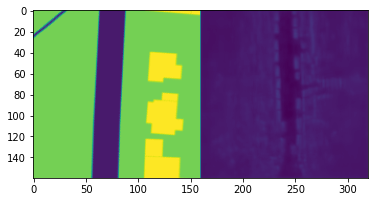

In [146]:
train = np.load(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\val_set.npy")
t_semseg= np.load(r"C:\Users\bjqb7h\Downloads\Thesis2022\train\Semseg\val_set.npy")
print(train.shape,t_semseg.shape)
plt.imshow(np.hstack((train[40],t_semseg[40])))

In [5]:
dx_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\dxTrue.npy')  # Shape: (num_samples,)
dy_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\dyTrue.npy')
dx = dx_array/0.000014
dy = dy_array/0.000017
np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\val\true_val_dxL.npy', dx[1255:1673])
np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\val\true_val_dyL.npy', dy[1255:1673])

In [97]:
import numpy as np

total_frames = 41

# Load the dx and dy arrays for 41 frames
dx_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\true_dxL.npy')  # Replace 'dx_array.npy' with the path to your dx array file
dy_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\true_dyL.npy')  # Replace 'dy_array.npy' with the path to your dy array file

# Generate and store gt_mat for individual frames
for i in range(total_frames):
    dx = dx_array[i]
    dy = dy_array[i]

    # Create gt_mat with identity matrix and populate dx and dy
    gt_mat = np.eye(4)
    gt_mat[0, 3] = dx
    gt_mat[1, 3] = dy

    # Store gt_mat for the current frame
    np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\gt_mat.npy', gt_mat)

In [6]:
gps_data_val = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\val\GPS_val_data.npy')
sem_data_val = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\val\Sem_val_data.npy')
labels = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\val\Targets_val.npy')
print(gps_data_val.shape,sem_data_val.shape,labels.shape)

(418, 160, 160) (418, 160, 160) (418, 6)


In [5]:
GPSM = h5py.File(r'C:\Users\bjqb7h\Downloads\Thesis2022\NUMPY\New\New Logs pt 2\AtCityBMW_Applanix-20220318T084714Z489GPSNOISE1.hdf5','r')